In [0]:
# required imports
import sys 
from collections import OrderedDict
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  


import torch
import torchvision 
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# mount the google drive to download the datasets
from google.colab import drive
drive.mount('/content/drive')
# project_path = '~/.pytorch/CIFAR10_data/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
project_path = '/content/drive/My Drive/cifar10/'

In [0]:
# create transforms to load the images, nothing much is needed here. 
transform = transforms.Compose(
                        [transforms.ToTensor(),
                        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [5]:
# download CIFAR 10 training set
trainset = torchvision.datasets.CIFAR10(root= project_path+'/data', train=True,
                                        download=True, transform=transform)

# load the trainning set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# download the test data
testset = torchvision.datasets.CIFAR10(root= project_path+'/data', train=False,
                                        download=True, transform=transform)

# load the test data
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# check those manually on the dataset site: https://www.cs.toronto.edu/~kriz/cifar.html 

Files already downloaded and verified
Files already downloaded and verified


In [34]:
testset[0]

(tensor([[[ 0.2392,  0.2471,  0.2941,  ...,  0.0745, -0.0118, -0.0902],
          [ 0.1922,  0.1843,  0.2471,  ...,  0.0667, -0.0196, -0.0667],
          [ 0.1843,  0.1843,  0.2392,  ...,  0.0902,  0.0196, -0.0588],
          ...,
          [-0.4667, -0.6706, -0.7569,  ..., -0.7020, -0.8980, -0.6863],
          [-0.5216, -0.6157, -0.7255,  ..., -0.7961, -0.7725, -0.8431],
          [-0.5765, -0.5608, -0.6471,  ..., -0.8118, -0.7333, -0.8353]],
 
         [[-0.1216, -0.1294, -0.0902,  ..., -0.2549, -0.2863, -0.3333],
          [-0.1216, -0.1373, -0.1059,  ..., -0.2549, -0.2863, -0.3098],
          [-0.1373, -0.1451, -0.1294,  ..., -0.2314, -0.2549, -0.3020],
          ...,
          [-0.0275, -0.2157, -0.3098,  ..., -0.2392, -0.4980, -0.3333],
          [-0.0902, -0.2000, -0.3333,  ..., -0.3569, -0.3569, -0.4980],
          [-0.1608, -0.1765, -0.3020,  ..., -0.3961, -0.3412, -0.4745]],
 
         [[-0.6157, -0.6314, -0.6000,  ..., -0.7176, -0.7176, -0.7412],
          [-0.6000, -0.6863,

  car horse truck plane


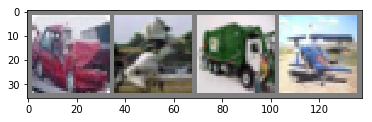

In [6]:
# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(imgs)) 

# notice who we converted the class idx to labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# run this cell multiple times and notice diff images

In [7]:
# divide the training dataset into the required groups Make sure they are balanced
# original trainset is made of 50k images

total_size = len(trainset)
split1 = total_size // 4
split2 = split1 * 2
split3 = split1 * 3

print(total_size, split1, split2, split3)

indices = list(range(total_size))

# two groups to train the shadow (in and out)
shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]

# two groups to train the Target (in and out)
target_train_idx = indices[split2:split3]
target_out_idx = indices[split3:]

50000 12500 25000 37500


In [0]:
batch_size = 4

# divide and load shadow train in and out
shadow_train_sampler = SubsetRandomSampler(shadow_train_idx) # Pytorch function
shadow_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_train_sampler)

shadow_out_sampler = SubsetRandomSampler(shadow_out_idx) # Pytorch function
shadow_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_out_sampler)

# divide and load Target in and out
target_train_sampler = SubsetRandomSampler(target_train_idx) # Pytorch function
target_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_train_sampler)

target_out_sampler = SubsetRandomSampler(target_out_idx) # Pytorch function
target_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_out_sampler)


In [0]:
# create a CNN
# Input shape (3, 32, 32) 
# architecture: simple. 2 conv and 2 Max pool, followed by 2 fc (120, 84) 
# output of fc is 10 because we have 10 classes!

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [0]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)

In [0]:
target_model = Net()

In [12]:
# initalize a target model and train it

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(target_model.parameters(), lr=0.001)

# let the magic begin
for epoch in range(50):  

    running_loss = 0
    
    for i, data in enumerate(target_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # make a prediction: forward prop
        output = target_model(inputs)
        
        # calculate the loss
        loss = criterion(output, labels)
        
        # calculate gradients
        loss.backward()
        
        # updaate weights in backprop
        optimizer.step()
        
        running_loss += loss.item()
            

    # print statistics
    print('Epoch {} loss {}'.format(epoch, loss))
        
        

print('Finished Training the Target model...')

Epoch 0 loss 2.287034511566162
Epoch 1 loss 2.2235891819000244
Epoch 2 loss 2.222200393676758
Epoch 3 loss 2.401151180267334
Epoch 4 loss 1.5556485652923584
Epoch 5 loss 1.9683756828308105
Epoch 6 loss 1.7281196117401123
Epoch 7 loss 1.8967417478561401
Epoch 8 loss 1.515014886856079
Epoch 9 loss 1.3012360334396362
Epoch 10 loss 2.0363047122955322
Epoch 11 loss 2.0609304904937744
Epoch 12 loss 0.8777512311935425
Epoch 13 loss 1.6446969509124756
Epoch 14 loss 1.70819091796875
Epoch 15 loss 1.2218401432037354
Epoch 16 loss 1.7837920188903809
Epoch 17 loss 1.5525791645050049
Epoch 18 loss 1.687563180923462
Epoch 19 loss 1.1957896947860718
Epoch 20 loss 1.4775322675704956
Epoch 21 loss 2.884528636932373
Epoch 22 loss 1.2245359420776367
Epoch 23 loss 1.1168580055236816
Epoch 24 loss 1.4372315406799316
Epoch 25 loss 0.9721407294273376
Epoch 26 loss 0.6936682462692261
Epoch 27 loss 1.933525800704956
Epoch 28 loss 1.8137125968933105
Epoch 29 loss 0.26816606521606445
Epoch 30 loss 1.276127934455

In [13]:
# calculate the accuracy of the Target Model
correct = 0
total = 0

with torch.no_grad():
    for data in target_out_loader:
        images, labels = data
        outputs = target_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %




---



In [0]:
torch.save(target_model.state_dict(), 'checkpoint.pth')

In [20]:
state_dict = torch.load('checkpoint.pth')
target_model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [17]:
# initalize a Shadow Model and Train it
# for the first ICP, your shadow model can have the same CNN architecture and hyperparameters

shadow_model = Net()
shadow_criterion = nn.CrossEntropyLoss()
shadow_optimizer = optim.SGD(shadow_model.parameters(), lr=0.001)

# let the magic begin
for epoch in range(50):  

    running_loss = 0
    
    for i, data in enumerate(shadow_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        shadow_optimizer.zero_grad()

        # forward + backward + optimize
        # make a prediction: forward prop
        output = shadow_model(inputs)
        
        # calculate the loss
        loss = criterion(output, labels)
        
        # calculate gradients
        loss.backward()
        
        # updaate weights in backprop
        shadow_optimizer.step()
        
        running_loss += loss.item()
            

    # print statistics
    print('Epoch {} loss {}'.format(epoch, loss))

print('Finished Training the Shadow model')

Epoch 0 loss 2.3352644443511963
Epoch 1 loss 2.29719877243042
Epoch 2 loss 2.2538747787475586
Epoch 3 loss 2.221916675567627
Epoch 4 loss 2.962458610534668
Epoch 5 loss 1.66731858253479
Epoch 6 loss 1.8071935176849365
Epoch 7 loss 1.790611982345581
Epoch 8 loss 1.6060004234313965
Epoch 9 loss 1.6123257875442505
Epoch 10 loss 1.837048053741455
Epoch 11 loss 1.2671312093734741
Epoch 12 loss 1.5290412902832031
Epoch 13 loss 1.9907810688018799
Epoch 14 loss 1.1075338125228882
Epoch 15 loss 1.090780258178711
Epoch 16 loss 1.0936388969421387
Epoch 17 loss 1.2463314533233643
Epoch 18 loss 1.8890342712402344
Epoch 19 loss 0.9045959115028381
Epoch 20 loss 0.9605705142021179
Epoch 21 loss 1.135425090789795
Epoch 22 loss 1.8436710834503174
Epoch 23 loss 0.49497413635253906


KeyboardInterrupt: ignored

In [0]:
torch.save(shadow_model.state_dict(), 'shadow_checkpoint.pth')

In [18]:
# calculate the accuracy of the Shadow Model
correct = 0
total = 0

with torch.no_grad():
    for data in shadow_out_loader:
        images, labels = data
        outputs = shadow_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 49 %


In [0]:
# freeze the Shadow model 
shadow_model.eval()

for param in shadow_model.parameters():
  param.requires_grad = False

# make predictions on both datasets (shadow_in and shdow_out)
shadow_data = []

for inputs, labels in shadow_train_loader:
  predictions = shadow_model(inputs)
  
  for i in range(predictions.shape[0]):
    shadow_data.append((predictions[i], 1))
  
for inputs, labels in shadow_out_loader:
  predictions = shadow_model(inputs)
  
  for i in range(predictions.shape[0]):
    shadow_data.append((predictions[i], 0))

# create a new dataset of the shape [predictions(shadow_in), 1], [predicitons(shadow_out), 1] and zip them together


In [0]:
# Create attack dataloader
attack_train_loader = torch.utils.data.DataLoader(shadow_data, batch_size=4, shuffle=True)

In [0]:
# create the Attack Model: A NN binary classifier {0, 1}
attack_model = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(10, 5)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(5, 2))
                          ]))

In [73]:
# the input to this model is the propability distribution vector of size 10
# and the output is either 0 (input was not included in training) or 1

# initalize a Shadow Model and Train it
# for the first ICP, your shadow model can have the same CNN architecture and hyperparameters

criterion = nn.CrossEntropyLoss()
attack_opt = optim.SGD(attack_model.parameters(), lr=0.001)

# let the magic begin
for epoch in range(20):  

    running_loss = 0
    
    for i, data in enumerate(attack_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        attack_opt.zero_grad()

        # forward + backward + optimize
        # make a prediction: forward prop
        output = attack_model(inputs)
        
        # calculate the loss
        loss = criterion(output, labels)
        
        # calculate gradients
        loss.backward()
        
        # updaate weights in backprop
        attack_opt.step()
        
        running_loss += loss.item()
            

    # print statistics
    print('Epoch {} loss {}'.format(epoch, loss))

print('Finished Training the Shadow model')

Epoch 0 loss 0.6730378866195679
Epoch 1 loss 0.6698541045188904
Epoch 2 loss 0.6928651332855225
Epoch 3 loss 0.7105040550231934
Epoch 4 loss 0.702652096748352
Epoch 5 loss 0.6982937455177307
Epoch 6 loss 0.7161573767662048
Epoch 7 loss 0.7023587226867676
Epoch 8 loss 0.6896083354949951
Epoch 9 loss 0.694150447845459
Epoch 10 loss 0.687923789024353
Epoch 11 loss 0.7035459280014038
Epoch 12 loss 0.6941201686859131
Epoch 13 loss 0.7074728012084961
Epoch 14 loss 0.7059978246688843
Epoch 15 loss 0.6940752267837524
Epoch 16 loss 0.7144498825073242
Epoch 17 loss 0.7077149748802185
Epoch 18 loss 0.6824926733970642
Epoch 19 loss 0.6972743272781372
Finished Training the Shadow model


In [0]:
torch.save(attack_model.state_dict(), 'attack_checkpoint.pth')

In [0]:
# calculate the recall and precision of your attack network using the Target_out and Target_in datasets
# to do so, take a random numer of datapoints, run them throw the target model,
# and then input the output of the target model to your attack network 
# you already know the target_in and target_out samples, so use that info to evaluate the attack model


# Run attack agains the target model
actual_value = []
pred_value = []

attack_model.eval()

for param in attack_model.parameters():
  param.requires_grad = False

for inputs, labels in target_train_loader:
  
  # Get probability output of target model
  output = target_model(inputs)
  
  # Run through attack model
  pred = attack_model(output)
  
  # Pull out top class
  top_p, top_class = pred.topk(1, dim=1)
  
  for i in range(top_class.shape[0]):
    pred_value.append(top_class[0].item())
    actual_value.append(1)
    
for inputs, labels in target_out_loader:
  
  # Get probability output of target model
  output = target_model(inputs)
  
  # Run through attack model
  pred = attack_model(output)
  
  # Pull out top class
  top_p, top_class = pred.topk(1, dim=1)
  
  for i in range(top_class.shape[0]):
    pred_value.append(top_class[0].item())
    actual_value.append(0)


In [0]:
for i in range(len(actual_value)):
  print("Actual: {}   Prediction: {}".format(actual_value[i], pred_value[i]))

In [75]:
# Calculate recall and precision
# precison = true positive / true positive + false positive
true_pos = 0
false_neg = 0

total_positive = sum(pred_value)
for i in range(len(actual_value)):
  if (pred_value[i] == 1) and (actual_value[i] == 1):
    true_pos += 1
  elif (pred_value[i] == 0 and actual_value[i] == 1):
    false_neg += 1
    
print('True positive: {} Total Positive: {} Precision: {}'.format(true_pos, total_positive, true_pos / total_positive))
print('Recall: {}', true_pos / (true_pos + false_neg))

True positive: 8892 Total Positive: 18040 Precision: 0.4929046563192905
Recall: {} 0.71136


Great! At this point, you must have created a succesfful attack model that can detect whether a datapoint was used in training a target mode or not. 
* A successful attack model is one with a precision/recall higher than 85% -- you are using same architecture and are aware of the data classes

 
 Can you suggest any defense mechanism? If yes, Apply them to your solution and re-evaluate your attack model. How did your defense mecanism affect the accuracy of the target model? How did it affect the recall and precision of the Attack model?